In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import multiprocessing as mp
import matplotlib.pyplot as plt

from deap import base, creator, tools, cma

from utils import dt2int
from torchdiffeq import odeint
from collections import namedtuple
from scipy.integrate import solve_ivp

from data import C3RData, interpolate
from tqdm.notebook import tqdm, trange
from sklearn.metrics import mean_squared_error, mean_squared_log_error

In [2]:
# better plots
sns.set_style('whitegrid')

# better progressbars
tqdm.pandas()

In [3]:
# required data structures
Action = namedtuple("patient_action", ['CHO', 'insulin'])

In [4]:
# load dataset
c3r = C3RData(data_dir="data/")

# get data for a certain case
deident_id = 2
from_dt = f"2014-05-05 00:00:00"
to_dt = f"2014-05-08 00:00:00"

# destructure data
cgm_data, meal_data, insulin_data = c3r.get_case(deident_id, from_dt, to_dt)
data_t, data_CGM, data_CHO, data_insulin = interpolate(cgm_data, meal_data, insulin_data)

# normalize time
data_t -= data_t[0]

# scale down to minutes
data_t = data_t / 60.0

# negate delay
data_CHO = np.roll(data_CHO, -200)
data_insulin = np.roll(data_insulin, -200)

# clean
data_CHO = np.nan_to_num(data_CHO, nan=data_CHO[0])
data_insulin = np.nan_to_num(data_insulin, nan=data_insulin[0])

In [5]:
# load test data
test_from_dt = f"2014-05-09 00:00:00"
test_to_dt = f"2014-05-10 00:00:00"

# destructure data
test_cgm_data, test_meal_data, test_insulin_data = c3r.get_case(deident_id, test_from_dt, test_to_dt)
test_data_t, test_data_CGM, test_data_CHO, test_data_insulin = interpolate(test_cgm_data, test_meal_data, test_insulin_data)

# normalize time
test_data_t -= test_data_t[0]

# scale down to minutes
test_data_t = test_data_t / 60.0

# clean
test_data_CHO = np.nan_to_num(test_data_CHO, nan=test_data_CHO[0])
test_data_insulin = np.nan_to_num(test_data_insulin, nan=test_data_insulin[0])

In [6]:
# load parameters
orig_params = pd.read_csv("parameters/vpatient_params.csv")
mean_params = orig_params.loc[orig_params["Name"] == "adult#001"].squeeze()
mean_params = mean_params.rename(lambda x: x.replace(" ", ""))
adult_params = orig_params[orig_params.Name.str.contains("adult")]

min_params = adult_params.min()
max_params = adult_params.max()

def get_param(p, p_min, p_max):
    # p_min /= 10
    # p_max *= 10
    return ((np.tanh(p) + 1) / 2) * (p_max - p_min) + p_min

In [7]:
in_time = data_t
# in_CHO = data_CHO
in_CHO = data_CHO / 2
# in_insulin = data_insulin
in_insulin = np.where(data_insulin > data_insulin[0], data_insulin / 2, data_insulin)

def ode(t, x, p):
    # instantiate derivatives
    dxdt = np.zeros(13)

    # destructure params
    _kabs, _kmax, _kmin, _k2, _k1, _ki, _kp2, _kp3, _ke1, _kp1 = p

    # fixed parameters
    params = mean_params
    kabs = get_param(_kabs, min_params["kabs"], max_params["kabs"])
    kmax = get_param(_kmax, min_params["kmax"], max_params["kmax"])
    kmin = get_param(_kmin, min_params["kmin"], max_params["kmin"])
    k2 = get_param(_k2, min_params["k2"], max_params["k2"])
    k1 = get_param(_k1, min_params["k1"], max_params["k1"])
    ki = get_param(_ki, min_params["ki"], max_params["ki"])
    kp2 = get_param(_kp2, min_params["kp2"], max_params["kp2"])
    kp3 = get_param(_kp3, min_params["kp3"], max_params["kp3"])
    ke1 = get_param(_ke1, min_params["ke1"], max_params["ke1"])
    kp1 = get_param(_kp1, min_params["kp1"], max_params["kp1"])

    # get current action
    t_mask = np.abs(in_time - t).argmin()
    action = Action(CHO=in_CHO[t_mask], insulin=in_insulin[t_mask])

    d = action.CHO * 1000 # g -> mg
    insulin = action.insulin * 6000 / params.BW

    # glucose in the stomach
    qsto = x[0] + x[1]

    last_foodtaken = 0
    if t_mask > 0:
        last_foodtaken = in_CHO[t_mask - 1]
    
    Dbar = last_foodtaken * 1000 # unit: mg

    # stomach solid
    dxdt[0] = -kmax * x[0] + d

    if Dbar > 0:
        aa = 5 / 2 / (1 - params.b) / Dbar
        cc = 5 / 2 / params.d / Dbar
        kgut = kmin + (kmax - kmin) / 2 * (
            np.tanh(aa * (qsto - params.b * Dbar))
            - np.tanh(cc * (qsto - params.d * Dbar))
            + 2
        )
    else:
        kgut = kmax

    # stomach liquid
    dxdt[1] = kmax * x[0] - x[1] * kgut

    # intestine
    dxdt[2] = kgut * x[1] - kabs * x[2]

    # Rate of appearance
    Rat = params.f * kabs * x[2] / params.BW
    # Glucose Production
    EGPt = kp1 - kp2 * x[3] - kp3 * x[8]
    # Glucose Utilization
    Uiit = params.Fsnc

    # renal excretion
    if x[3] > params.ke2:
        Et = ke1 * (x[3] - params.ke2)
    else:
        Et = 0

    # glucose kinetics
    # plus dextrose IV injection input u[2] if needed
    dxdt[3] = max(EGPt, 0) + Rat - Uiit - Et - k1 * x[3] + k2 * x[4]
    dxdt[3] = (x[3] >= 0) * dxdt[3]

    Vmt = params.Vm0 + params.Vmx * x[6]
    Kmt = params.Km0
    Uidt = Vmt * x[4] / (Kmt + x[4])
    dxdt[4] = -Uidt + k1 * x[3] - k2 * x[4]
    dxdt[4] = (x[4] >= 0) * dxdt[4]

    # insulin kinetics
    dxdt[5] = (
        -(params.m2 + params.m4) * x[5]
        + params.m1 * x[9]
        + params.ka1 * x[10]
        + params.ka2 * x[11]
    )  # plus insulin IV injection u[3] if needed
    It = x[5] / params.Vi
    dxdt[5] = (x[5] >= 0) * dxdt[5]

    # insulin action on glucose utilization
    dxdt[6] = -params.p2u * x[6] + params.p2u * (It - params.Ib)

    # insulin action on production
    dxdt[7] = -ki * (x[7] - It)

    dxdt[8] = -ki * (x[8] - x[7])

    # insulin in the liver (pmol/kg)
    dxdt[9] = -(params.m1 + params.m30) * x[9] + params.m2 * x[5]
    dxdt[9] = (x[9] >= 0) * dxdt[9]

    # subcutaneous insulin kinetics
    dxdt[10] = insulin - (params.ka1 + params.kd) * x[10]
    dxdt[10] = (x[10] >= 0) * dxdt[10]

    dxdt[11] = params.kd * x[10] - params.ka2 * x[11]
    dxdt[11] = (x[11] >= 0) * dxdt[11]

    # subcutaneous glucose
    dxdt[12] = -params.ksc * x[12] + params.ksc * x[3]
    dxdt[12] = (x[12] >= 0) * dxdt[12]

    return dxdt

In [8]:
# initial conditions
x_0 = mean_params.iloc[2:15].to_numpy()

# timespan
tspan = (data_t[0], data_t[-1])
t_eval = data_t

In [9]:
# initial parameter guess
p_guess = np.array([
    mean_params["kabs"], 
    mean_params["kmax"],
    mean_params["kmin"],
    mean_params["k2"],
    mean_params["k1"],
    mean_params["ki"],
    mean_params["kp2"],
    mean_params["kp3"],
    mean_params["ke1"],
    mean_params["kp1"]
])

In [10]:
# compute loss for one parameter set
def loss(p):
    try:
        sol = solve_ivp(ode, tspan, x_0, t_eval=t_eval, args=(p,), method="BDF")
        sol_CGM = sol.y[12] / mean_params["Vg"]

        try:
            return [mean_squared_log_error(sol_CGM, data_CGM)]
        except:
            return [1e10]

    except:
        print(p)

# Optimization

In [11]:
# evolutionary algorithm parameters
NGEN = 200
SIGMA = 5.0
LAMBDA = 100

# evolutionary algorithm setup
creator.create("FitnessMin", base.Fitness, weights=[-1.0])
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("evaluate", loss)

# enable multiprocessing
pool = mp.Pool()
toolbox.register("map", pool.map)

# ES
strategy = cma.Strategy(centroid=p_guess, sigma=SIGMA, lambda_=LAMBDA)
toolbox.register("generate", strategy.generate, creator.Individual)
toolbox.register("update", strategy.update)

# track best individuals
hof = tools.HallOfFame(1)
stats = tools.Statistics(lambda i: i.fitness.values)
stats.register("avg_loss", np.mean)
stats.register("min_loss", np.min)
stats.register("max_loss", np.max)

# train
pbar = trange(NGEN)
for _ in pbar:
    # generate a new population
    population = toolbox.generate()

    # evaluate the individuals
    fitnesses = toolbox.map(toolbox.evaluate, population)
    for ind, fit in zip(population, fitnesses):
        ind.fitness.values = fit

    if hof is not None:
        hof.update(population)

    # update the strategy with the evaluated individuals
    toolbox.update(population)
    record = stats.compile(population) if stats is not None else {}
    pbar.set_postfix(min_loss=record["min_loss"])

best_params = hof.items[0]

  0%|          | 0/200 [00:00<?, ?it/s]

In [12]:
# destructure params
_kabs, _kmax, _kmin, _k2, _k1, _ki, _kp2, _kp3, _ke1, _kp1 = best_params

# fixed parameters
kabs = get_param(_kabs, min_params["kabs"], max_params["kabs"])
kmax = get_param(_kmax, min_params["kmax"], max_params["kmax"])
kmin = get_param(_kmin, min_params["kmin"], max_params["kmin"])
k2 = get_param(_k2, min_params["k2"], max_params["k2"])
k1 = get_param(_k1, min_params["k1"], max_params["k1"])
ki = get_param(_ki, min_params["ki"], max_params["ki"])
kp2 = get_param(_kp2, min_params["kp2"], max_params["kp2"])
kp3 = get_param(_kp3, min_params["kp3"], max_params["kp3"])
ke1 = get_param(_ke1, min_params["ke1"], max_params["ke1"])
kp1 = get_param(_kp1, min_params["kp1"], max_params["kp1"])

In [13]:
np.savetxt("results/best_params_evo.csv", np.array((kabs, kmax, kmin, k2, k1, ki, kp2, kp3, ke1, kp1)), delimiter=",")
print("Done. Saved to results/best_params_evo.csv")

Done. Saved to results/best_params_evo.csv


Done. Saved to results/fit_evo.png


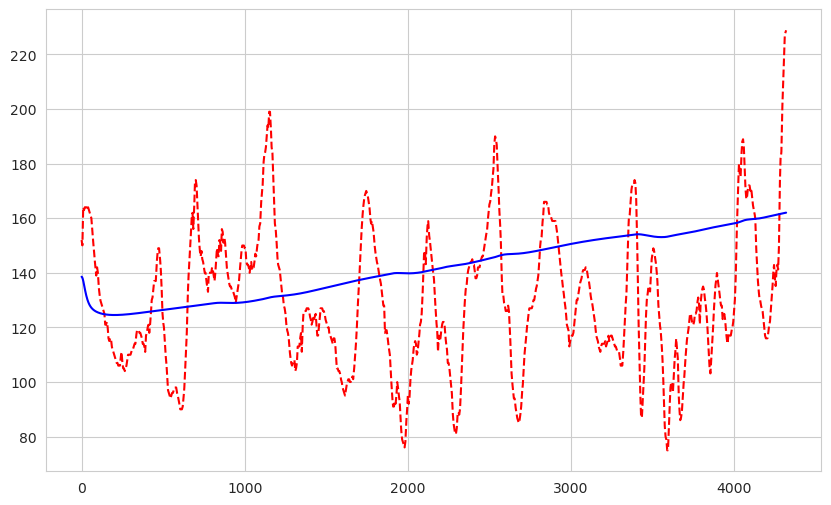

In [14]:
sol = solve_ivp(ode, tspan, x_0, t_eval=t_eval, args=(best_params,))
sol_g = solve_ivp(ode, tspan, x_0, t_eval=t_eval, args=(p_guess,))

sol_t = sol.t
sol_CGM = sol.y[12] / mean_params["Vg"]

plt.figure(figsize=(10, 6))
plt.plot(data_t, data_CGM, "r--")
plt.plot(sol_t, sol_CGM, "b")
plt.savefig("results/fit_evo.png")
print("Done. Saved to results/fit_evo.png")